# Clustering으로 음악 플레이리스트 나누기 

**목차**  
[1. 스포티파이 api를 활용해 나의 플레이리스트 정보 얻기](#1-스포티파이-api를-활용해-나의-플레이리스트-정보-얻기)  
[2. 사용할 특징을 골라 학습 데이터 구성하기](#2-사용할-특징을-골라-학습-데이터-구성하기)  
[3. 데이터 표준화](#3-데이터-표준화)  
[4. 주성분분석_PCA](#4-주성분분석pca)  
[5. 클러스터링](#5-클러스터링)  
[6. 군집별 특징](#6-군집별-특징)  
[7. 추가(변수선택방식)](#7-추가-변수-선택-방식)

## 1. 스포티파이 api를 활용해 나의 플레이리스트 정보 얻기

### 필요한 라이브러리와 스포티파이 api

[출처] https://developer.spotify.com/ : 스포티파이 개발자 홈페이지

*아래 링크를 통해 이 노트북을 주피터 노트북 뷰어(nbviewer.org)로 볼 수 있습니다.*

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.org/gist/anc5557/cbb2089c44fa2940a80dcc501eecc9ba"><img src="https://jupyter.org/assets/share.png" width="60" />주피터 노트북 뷰어로 보기</a>
  </td>
</table>

In [1]:
# colab에서 실행시 아래 추가

# !pip install spotipy
# !pip install pandas

In [2]:
import spotipy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import spotipy.util as util
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from pprint import pprint
from spotipy.oauth2 import SpotifyClientCredentials
from yellowbrick.cluster import KElbowVisualizer

In [3]:
pd.set_option('display.max_rows', 100)

[참고자료] https://kunduz.tistory.com/entry/Spotify-%EC%8A%A4%ED%8F%AC%ED%8B%B0%ED%8C%8C%EC%9D%B4-1-Spotify-OPEN-API-%EA%B0%80%EC%9E%85?category=937068 : 스포티파이 API ID, 비밀키 얻기


[코드출처] https://github.com/plamere/spotipy : API 코드

In [4]:
cid = ''  # API ID
secret = '' # 비밀키
username = '' 

# 스포티파이 인증
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=cid, client_secret=secret))

### 스포티파이 api 활용을 위한 변수 설정
변수
+ 유저이름 -> username
+ playlist_url에서 필요한 부분 추출 -> playlist_id

In [5]:
playlist_url = 'https://open.spotify.com/playlist/4M6ReCC7rLDVilDXR8N5eJ?si=53c6771df2824043'
playlist_yet_id = playlist_url.split('/')[4]
playlist_id = playlist_yet_id.split('?')[0]

### 플레이리스트에 있는 노래 정보 가져오기

정보
+ 곡 이름 -> track_name
+ 가수 이름 -> artist_name
+ 노래 주소 -> track_uri

[코드참고] https://github.com/sejaldua/music-clustering/blob/master/notebook.ipynb

In [6]:
offset = 0
tracks, track_uri, track_names, artist_name = [], [], [], []

# 트랙 정보를 가져올 때 한번에 가져올수 있는 제한이 있다. 100개
while True :
        results = sp.user_playlist_tracks(username, playlist_id, offset=offset)
        tracks += results['items']
        if results['next'] != None:
            offset += 100
        else:
            break

for track in tracks:
        artist_name.append(track['track']['artists'][0]['name'])
        track_names.append(track['track']['name'])
        track_uri.append(track['track']['uri'])
        

In [7]:
# 트랙 데이터프레임 만들기
df_base_track = pd.DataFrame({'track_name' : track_names,'artist_name' : artist_name, 'track_uri' : track_uri })
df_base_track

,track_name,artist_name,track_uri
0,Bawling,Primary,spotify:track:5qHgojWfVTUsGm6J9OG8ix
1,yayou hoi,sogumm,spotify:track:72uerGsS3eLO72OU4fZLjj
2,Island,Primary,spotify:track:3C6AeHLPwcT8p8euqmxOeg
3,Rubber (Feat. OHHYUK),Primary,spotify:track:5YP7CyMqlERXKbS2Lycijm
4,Weekend,TAEYEON,spotify:track:0n1jo6k1GUzyrcXW2aS0iL
...,...,...,...
219,Tale 동화,MeloMance,spotify:track:1O6gfRnuWW3jRG77Tn8gHW
220,Gravity,TAEYEON,spotify:track:1fzLM4SRonzoHm723a2mP5
221,Take My Hand,Kassy,spotify:track:6YBfa6iDpybEPDcQsPi9D2
222,UN Village,BAEKHYUN,spotify:track:0WSTInLqMrT9po0LAHpZCJ


### 노래의 특징 추출
https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features

특징
+ danceability : 춤추기 적합한가? [0-1] 클수록 춤추기 좋음
+ energy : 에너지, [0-1], 빠르고 시끄럽고 노이즈가 많은 곡일수록 큼 ex) 데스메탈
+ loudness : 곡의 평균 음량, 일반적으로 -60 ~ 0dB
+ mode : 장조 1 단조 0
+ speechiness : 곡에서 음성단어의 비율, [0-1], 0.33 ~ 0.66을 가진 트랙은 음악과 음성 모두 포함
+ instrumentalness : 곡에 보컬 포함 여부, [0-1], 0.5이상은 악기 트랙, 랩같은 노래는 0에 가까움
+ liveness : 곡의 라이브 정도, 녹음에서 청중의 존재 감지
+ valence : 음원의 밝은 정도, [0-1], 밝고 행복하고 기쁘면 값이 높고 반대는 낮음
+ tempo : 템포 BPM, [0-300BPM]


In [8]:
feature = []
offset = 0
limit = 100

if len(track_uri) <= limit :
    results = sp.audio_features(track_uri)
else:
    while True :
        if len(track_uri) > limit-100:
            results = sp.audio_features(track_uri[offset : limit])
            feature += results
            offset += 100
            limit += 100
        else:
            break

df_feature = pd.DataFrame(feature)
df_track = pd.concat([df_base_track, df_feature], axis=1)

df_track.drop(['type','id','uri','track_href','analysis_url','duration_ms','time_signature'],axis=1,inplace=True)
df_track

        

,track_name,artist_name,track_uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,Bawling,Primary,spotify:track:5qHgojWfVTUsGm6J9OG8ix,0.757,0.624,1,-7.529,0,0.2540,0.4880,0.009030,0.1020,0.483,87.018
1,yayou hoi,sogumm,spotify:track:72uerGsS3eLO72OU4fZLjj,0.665,0.742,5,-5.128,1,0.0692,0.0619,0.000087,0.0446,0.525,99.972
2,Island,Primary,spotify:track:3C6AeHLPwcT8p8euqmxOeg,0.459,0.330,11,-8.740,1,0.0863,0.6470,0.001850,0.1090,0.177,92.639
3,Rubber (Feat. OHHYUK),Primary,spotify:track:5YP7CyMqlERXKbS2Lycijm,0.870,0.534,2,-8.334,1,0.1020,0.0776,0.000516,0.2550,0.836,109.994
4,Weekend,TAEYEON,spotify:track:0n1jo6k1GUzyrcXW2aS0iL,0.740,0.854,8,-2.209,1,0.0525,0.0783,0.000532,0.2530,0.856,114.029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,Tale 동화,MeloMance,spotify:track:1O6gfRnuWW3jRG77Tn8gHW,0.682,0.430,8,-5.287,1,0.0331,0.7620,0.000000,0.1260,0.526,99.970
220,Gravity,TAEYEON,spotify:track:1fzLM4SRonzoHm723a2mP5,0.597,0.515,10,-5.620,1,0.0382,0.0898,0.000001,0.1110,0.142,153.871
221,Take My Hand,Kassy,spotify:track:6YBfa6iDpybEPDcQsPi9D2,0.672,0.233,7,-9.293,1,0.0393,0.9440,0.000000,0.1460,0.297,83.971
222,UN Village,BAEKHYUN,spotify:track:0WSTInLqMrT9po0LAHpZCJ,0.674,0.589,6,-3.806,0,0.1120,0.2670,0.000000,0.3120,0.577,83.985


## 2. 사용할 특징을 골라 학습 데이터 구성하기

loudness, speechiness, danceability, energy, valence, tempo, instrumentalness만 뽑아 학습 데이터 구성

In [9]:
data = df_track[['loudness','mode','speechiness','danceability','energy','valence','tempo']]
data

,loudness,mode,speechiness,danceability,energy,valence,tempo
0,-7.529,0,0.2540,0.757,0.624,0.483,87.018
1,-5.128,1,0.0692,0.665,0.742,0.525,99.972
2,-8.740,1,0.0863,0.459,0.330,0.177,92.639
3,-8.334,1,0.1020,0.870,0.534,0.836,109.994
4,-2.209,1,0.0525,0.740,0.854,0.856,114.029
...,...,...,...,...,...,...,...
219,-5.287,1,0.0331,0.682,0.430,0.526,99.970
220,-5.620,1,0.0382,0.597,0.515,0.142,153.871
221,-9.293,1,0.0393,0.672,0.233,0.297,83.971
222,-3.806,0,0.1120,0.674,0.589,0.577,83.985


## 3. 데이터 표준화 


tempo와 loudness에 더 큰 가중치를 주지 않게 하기위해 평균이 0, 표준편차가 1로 표준화

sklearn의 StandardScaler 사용

[코드참고] 책 [파이썬 라이브러리를 활용한 머신러닝] p.202

In [10]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

## 4. 주성분분석_PCA

### 특징
특징 다루는 방법  
1. 변수 선택(selection) : 분석 목적에 맞는 소수 특징들을 고르는 방법  

    장점 : 선택한 변수를 해석하기 용이하다.  
    단점 : 변수 간 상관관계를 고려하기 어렵다.  

2. 변수 추출(extraction) : 변수들을 변환해 새로운 변수 추출  
    
    장점 : 변수 간 상관관계 고려할 수 있고, 노이즈, 차원축소  
    단점 : 추출된 변수는 변환된 변수기 때문에 해석이 어렵습니다. 


변수 추출 방법인 PCA로 진행하고 변수 선택 방식은 끝에서 추가로 보여드리겠습니다.


 ### PCA
 [참고자료]
 책[파이썬 라이브러리를 활용한 머신러닝] p.203  
 공돌이 수학정리노트 주성분 분석(PCA) https://angeloyeo.github.io/2019/07/27/PCA.html, https://youtu.be/YEdscCNsinU 

 PCA 주성분분석

 <img src="https://raw.githubusercontent.com/angeloyeo/angeloyeo.github.io/master/pics/2019-07-27_PCA/pics_eigen.png" width="400" height="400">  

 + 공분산 행렬을 이용해서 고유벡터에 정사영을 시켜주는 것
 + 원래의 데이터 분포를 최대한 보존하면서 고차원을 저차원으로 변환하는 방법
 + feature가 3개가 넘기 때문에 PCA하여 차원축소해 시각화한다.

[코드출처] https://github.com/sejaldua/music-clustering/blob/master/notebook.ipynb

In [11]:
pca = PCA()
pca.fit(data_scaled)
evr = pca.explained_variance_ratio_ # 주성분이 원본데이터를 얼마나 잘설명하는지
print(evr)

[0.38591566 0.18573468 0.12457853 0.11506676 0.11072749 0.04766119
 0.03031569]


### 주성분 개수 결정  
경험적으로 성분 개수는 explained_variance을 누적한 값이 0.8~0.9가 경험적으로 적합합니다.

[코드출처] https://github.com/sejaldua/music-clustering/blob/master/notebook.ipynb

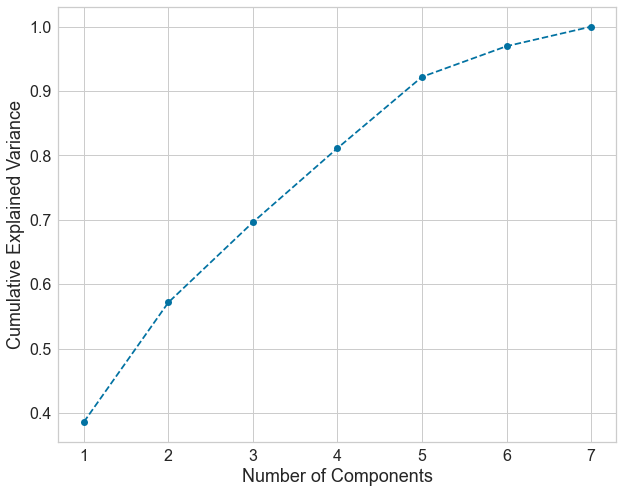

In [12]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1, len(data.columns)+1), evr.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Cumulative Explained Variance',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

[코드참고] 책 [파이썬 라이브러리를 활용한 머신러닝] p.209

In [13]:
pca = PCA(n_components=0.8) # Cumulative Explained Variance가 0.8이 되는 성분 개수
pca.fit(data_scaled)
scores_pca = pca.transform(data_scaled)

print("원본 데이터 형태:",str(data_scaled.shape))
print("축소된 데이터 형태:",str(scores_pca.shape))

원본 데이터 형태: (224, 7)
축소된 데이터 형태: (224, 4)


## 5. 클러스터링

### elbow method_엘보우 방법
+ k-평균 알고리즘에서 클러스터 개수는 선택하는 좋은 방법
+ 클러스터 개수를 늘려가면서 k-평균 이너셔 감소가 완만해지는 지점을 찾음
+ 여기서 이너셔는 클러스터 중심에서 클러스터에 속한 각 샘플간의 제곱거리 합

yellowblick의 KElbowVisualizer을 이용해 가장 적합한 k값 찾기

[코드출처] https://github.com/sejaldua/music-clustering/blob/master/notebook.ipynb

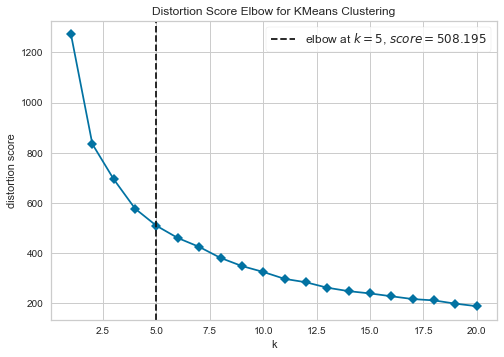

Optimal number of clusters: 5


In [14]:
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(1,21), timings=False)  #timings = true : 클러스터링 훈련에 필요한 시간 평가, k당 피팅 시간
visualizer.fit(scores_pca)
visualizer.show()
n_clusters = visualizer.elbow_value_
print("Optimal number of clusters:", n_clusters)

### k-means clustering
[그림출처] https://itstory1592.tistory.com/17  
![kmeansclusteringalgorithm](https://blog.kakaocdn.net/dn/eiVxaB/btq5j79KUJh/tK99PexS73gUmbkOJ96Ahk/img.gif)
#### 과정
[참고자료] 책 [파이썬 라이브러리를 활용한 머신러닝]  
    
1) 군집의 개수(K) 설정하기  
2) 초기 중심점 설정하기  
3) 중심점과 유클리드 거리로 가장 가까운 데이터를 군집에 할당  
4) 같은 군집의 평균이 되는 점으로 중심점 재설정  
5) 데이터를 군집에 재할당(배정)하기  
-> 더 이상 중심점 이동이 없을 때 까지 4, 5번 반복하기.

  
  
  



[코드참고] 책 [파이썬 라이브러리를 활용한 머신러닝] p.239

In [15]:
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(scores_pca)

KMeans(n_clusters=5, random_state=0)

In [16]:
component = pd.DataFrame(scores_pca)
component.columns = ["Component " + str(i+1) for i in range(pca.n_components_) ] #열 이름 지정

cluster = pd.DataFrame(kmeans.labels_)
cluster.columns = ["Cluster"]

df_cluster_componet = pd.concat([component, cluster], axis=1)
df_cluster_componet

,Component 1,Component 2,Component 3,Component 4,Cluster
0,-1.782921,1.929650,1.414180,0.937378,0
1,-1.065493,-0.522176,-0.680524,0.197586,3
2,1.920469,0.596621,0.113238,1.115346,2
3,-1.270680,0.867921,0.198096,-1.779460,3
4,-2.659861,-1.423600,-1.008467,-0.547868,3
...,...,...,...,...,...
219,-0.085861,0.054927,-0.849767,-0.258942,1
220,1.178975,-1.219993,-0.065825,-0.197388,4
221,1.539995,1.520392,-0.517180,-0.147498,2
222,-1.801481,0.921663,-0.405835,1.116624,3


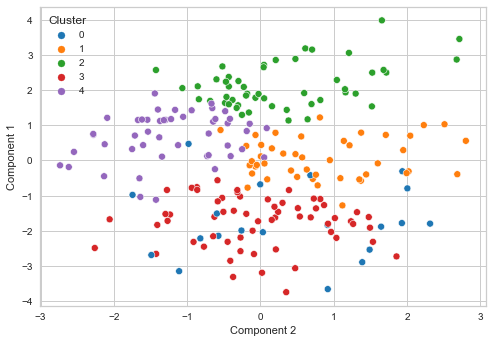

In [17]:
fig.set_size_inches( 30,  10)

sns.scatterplot(x="Component 2", y="Component 1" , hue=df_cluster_componet['Cluster'], palette = "tab10", data = df_cluster_componet)
plt.show()

In [18]:
# df_track에 cluster 합치기
df_track_cluster = pd.concat([df_track, cluster], axis=1)

## 6. 군집별 특징

In [19]:
test_cluster = df_track_cluster[['loudness','mode','speechiness','danceability','energy','valence','tempo','Cluster']]
test_cluster

,loudness,mode,speechiness,danceability,energy,valence,tempo,Cluster
0,-7.529,0,0.2540,0.757,0.624,0.483,87.018,0
1,-5.128,1,0.0692,0.665,0.742,0.525,99.972,3
2,-8.740,1,0.0863,0.459,0.330,0.177,92.639,2
3,-8.334,1,0.1020,0.870,0.534,0.836,109.994,3
4,-2.209,1,0.0525,0.740,0.854,0.856,114.029,3
...,...,...,...,...,...,...,...,...
219,-5.287,1,0.0331,0.682,0.430,0.526,99.970,1
220,-5.620,1,0.0382,0.597,0.515,0.142,153.871,4
221,-9.293,1,0.0393,0.672,0.233,0.297,83.971,2
222,-3.806,0,0.1120,0.674,0.589,0.577,83.985,3


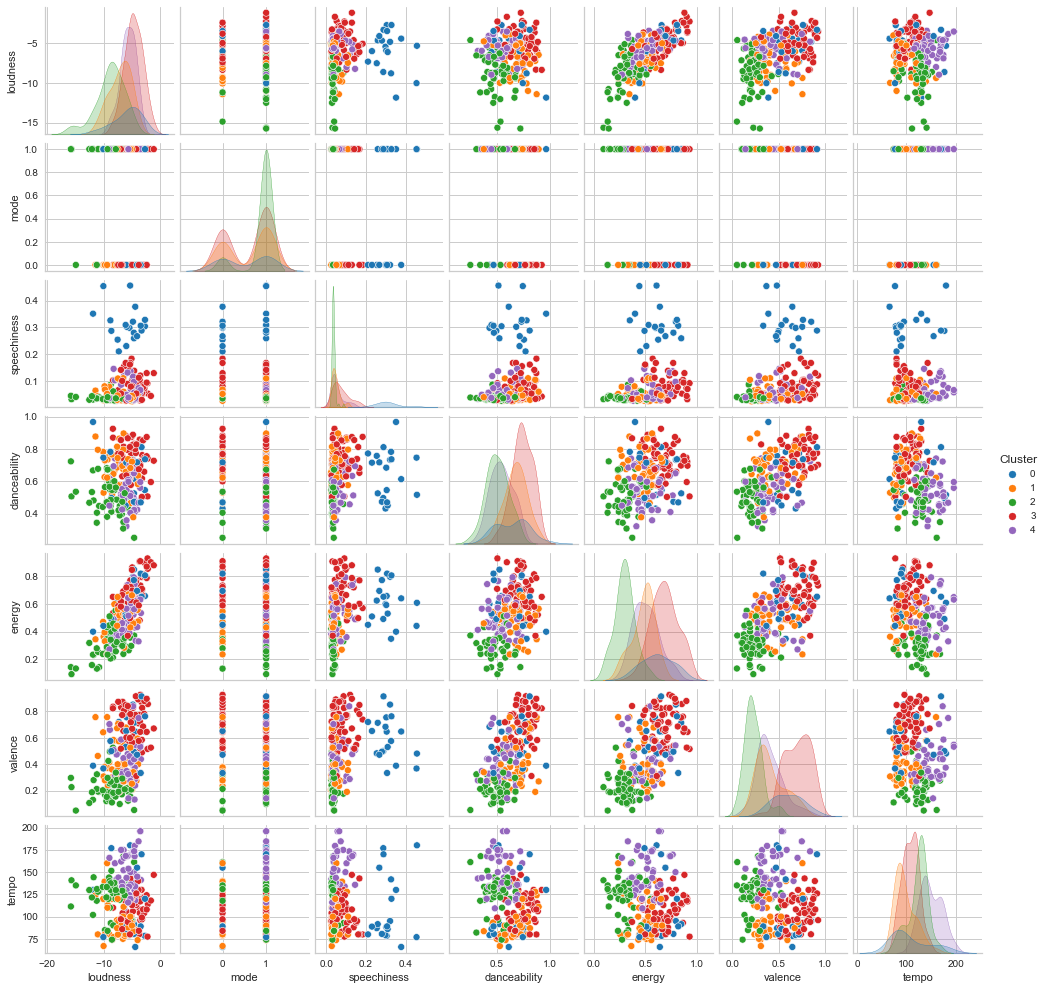

In [20]:
sns.pairplot(test_cluster, hue="Cluster", palette="tab10", height=2)
plt.show()

### 클러스터 특징의 경향 파악

앞서 말했듯이 변수 추출방식은 PCA로 상관관계를 고려해 변수를 추출했기 때문에 PCA한 변수로는 이 노래들의 특징을 알 수 없습니다.  
그렇기 때문에 정확하게 클러스터의 특징을 말할 수 없어 위 그래프를 이용해 경향 정도만 파악해보겠습니다.  
  
+ 클러스터 0 (파란색) : speechiness가 높은 노래, 곡에서 음성단어 비율이 높은 노래 -> 음악보다 음성이 더 많은 비율 차지하는 노래  
+ 클러스터 1 (주황색) : tempo, valence, loudness, danceability 모두 중간 정도 되는 노래  
+ 클러스터 2 (초록색) : energy, valence, danceability, loudness가 전체적으로 낮은 노래 -> 전체적으로 어둡고 춤추기 적합하지 않고 잔잔한 노래  
+ 클러스터 3 (빨간색) : 클러스터 2와 반대되는 노래 -> 전체적으로 밝고 시끄럽고 춤추기 좋은 노래  
+ 클러스터 4 (보라색) : tempo가 빠른 노래  

In [21]:
# 클러스터 별 노래 목록
df_track_cluster.loc[(df_track_cluster.Cluster == 3), ['Cluster','track_name','artist_name']]

,Cluster,track_name,artist_name
1,3,yayou hoi,sogumm
3,3,Rubber (Feat. OHHYUK),Primary
4,3,Weekend,TAEYEON
7,3,Traffic Control,GIRIBOY
8,3,The Time Is Now,GIRIBOY
9,3,What's Wrong (Feat. YUNHWAY),GIRIBOY
10,3,We (OUI) (Feat. sogumm),jeebanoff
23,3,"Beggar (Feat. YUNHWAY, Jhnovr, JUSTHIS)",GIRIBOY
24,3,The Bad Guys,Zion.T
27,3,Obsession,EXO


## 7. 추가 (변수 선택 방식)

### 피어스 상관분석(변수간 상관관계 파악)
feature간의 상관관계를 보여주는 피어스 상관분석을 했습니다.  
두 변수간의 Pearson correlation을 구하면 (-1, 1)사이의 값을 얻을 수 있습니다. -1로 갈수록 음의 상관관계, 1로 갈수록 양의 상관관계 의미하며, 0은 상관관계가 없다는 것을 의미합니다. 구하는 수식은 아래와 같습니다.


$$r_{xy} = \frac{Cov(x,y)}{S_{x}S_{y}} = \frac{\frac{1}{n-1}\sum_{i=1}^n(x_{i}-\bar x)(y_{i}-\bar y)}{S_{x}S_{y}}$$

+ -1.0 ~ -0.7 이면, 강한 음적 상관관계
+ -0.7 ~ -0.3 이면, 뚜렷한 음적 상관관계
+ -0.3 ~ -0.1 이면, 약한 음적 상관관계
+ -0.1 ~ +0.1 이면, 없다고 할 수 있는 상관관계
+ +0.1 ~ +0.3 이면, 약한 양적 상관관계
+ +0.3 ~ +0.7 이면, 뚜렷한 양적 상관관계
+ +0.7 ~ +1.0 이면, 강한 양적 상관관계  

[코드출처&참고자료] https://kaggle-kr.tistory.com/17?category=868316

<AxesSubplot:title={'center':'Correlation of Features'}>

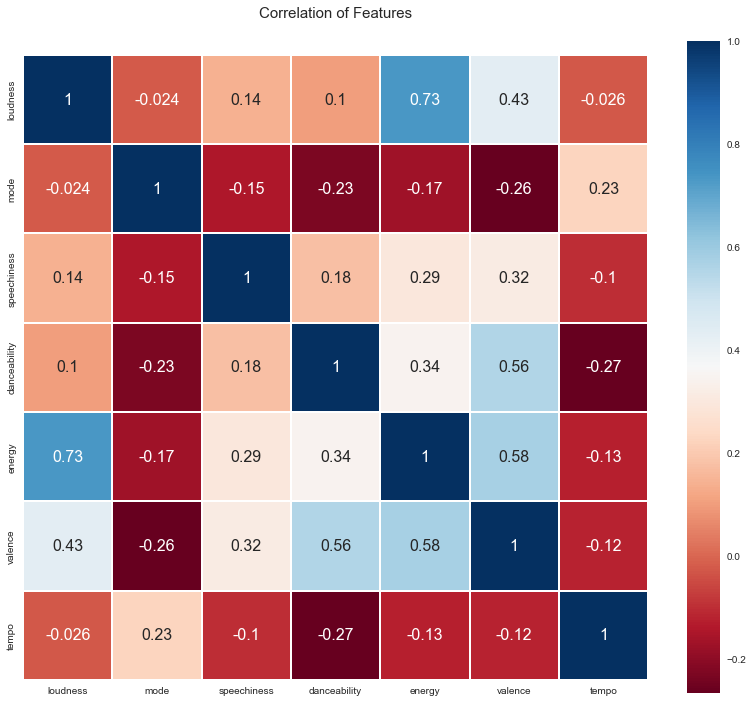

In [22]:
colormap = plt.cm.RdBu
plt.figure(figsize= (14, 12))
plt.title('Correlation of Features', y=1.05, size=15)
sns.heatmap(data.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size":16})

+ 뚜렷한 상관관계를 보이는 특징들

    energy - loudness  
    loudness - valence  
    valence - danceability  
    valence - energy  

### 변수 선택
서로 상관관계를 고려해 변수 선택  
+ energy, valence, danceability 중 하나 -> valence  
+ tempo

In [23]:
select_data = df_track[['valence','tempo']]

In [24]:
#데이터 표준화
scaler = StandardScaler()
select_data_scaled = scaler.fit_transform(select_data)

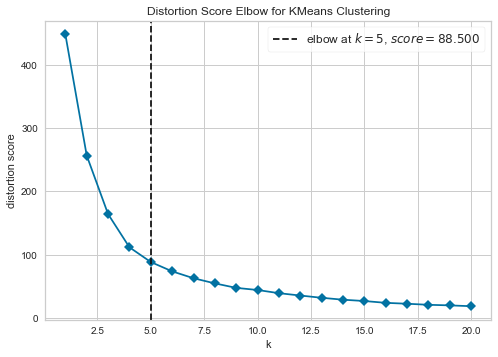

Optimal number of clusters: 5


In [25]:
# 엘보우방법
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(1,21), timings=False)  #timings = true : 클러스터링 훈련에 필요한 시간 평가, k당 피팅 시간
visualizer.fit(select_data_scaled)
visualizer.show()
n_clusters = visualizer.elbow_value_
print("Optimal number of clusters:", n_clusters)

In [26]:
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(select_data_scaled)

KMeans(n_clusters=5, random_state=0)

In [27]:
select_component = pd.DataFrame(select_data_scaled)
select_component.columns = select_data.columns

select_cluster = pd.DataFrame(kmeans.labels_)
select_cluster.columns = ["Cluster"]

df_select_cluster_componet = pd.concat([select_component, select_cluster], axis=1)

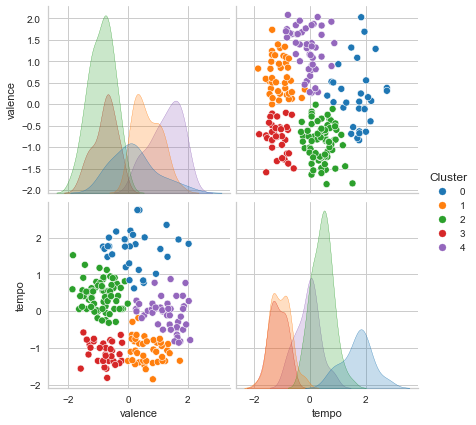

In [28]:
sns.pairplot(df_select_cluster_componet, hue="Cluster", palette="tab10", height=3)
plt.show()

### 클러스터별 분석

+ 클러스터 0 (파란색) : tempo가 빠른 노래 
+ 클러스터 1 (주황색) : 분위기가 밝고 tempo가 느린 노래
+ 클러스터 2 (초록색) : 분위기가 어둡고 tempo가 중간 정도인 노래 
+ 클러스터 3 (빨간색) : 분위기가 어둡고 tempo가 느린 노래
+ 클러스터 4 (보라색) : 분위기가 밝고 tempo가 중간 정도인 노래

In [29]:
df_select_track_cluster = pd.concat([df_track, select_cluster], axis=1)

In [30]:
df_select_track_cluster.loc[(df_select_track_cluster.Cluster == 4), ['Cluster','track_name','artist_name']]

,Cluster,track_name,artist_name
3,4,Rubber (Feat. OHHYUK),Primary
4,4,Weekend,TAEYEON
7,4,Traffic Control,GIRIBOY
8,4,The Time Is Now,GIRIBOY
17,4,"Turn Up! (Feat. M1NU, Veinyfl, Swervy, Layone,...",BIG Naughty
23,4,"Beggar (Feat. YUNHWAY, Jhnovr, JUSTHIS)",GIRIBOY
24,4,The Bad Guys,Zion.T
26,4,Cheap Coffee,Chang Kiha
27,4,Obsession,EXO
29,4,COVID-19 (feat. SUPERBEE),BUMKEY


## 8. 향후 계획
1. MFFCC(사람 청각구조를 방영한 정보) 주파수 음역대를 분석해 피쳐를 만들고 분류  
2. 가사를 분석해 감정 분석  

